<a href="https://colab.research.google.com/github/opi-lab/stsiva-workshop/blob/main/notebooks/stsiva_workshop_notebook02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camera calibration

*STSIVA Workshop - 2021*

**Speakers:**    
Jhacson Meza - [@jhacsonmeza](https://github.com/jhacsonmeza)    
Andrés G. Marrugo, PhD -     [@agmarrugo](https://github.com/agmarrugo)     
Universidad Tecnológica de Bolívar    

In this example, we will be calibrating a camera with openCV.

*The source of this notebook is located at https://github.com/opi-lab/stsiva-workshop/*

*Useful intro about [Colab](https://colab.research.google.com/notebooks/welcome.ipynb)*

*Useful intro about [OpenCV](https://opencv.org/)*

In [74]:
# Let's import the necessary libraries
import numpy as np
import cv2 
import matplotlib.pylab as plt
from google.colab.patches import cv2_imshow # for image display
# import pandas as pd
from skimage import io
from PIL import Image 
import urllib.request

In [75]:
IMAGE_URL = 'https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_0{}.png'

NumImages = 8
ImgBaseName = 'pose_0{}.png'

print('Donwloading images...')
for i in range(0, NumImages):
  urllib.request.urlretrieve(IMAGE_URL.format(i), ImgBaseName.format(i))
  print(IMAGE_URL.format(i))

print('Done.')

Donwloading images...
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_00.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_01.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_02.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_03.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_04.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_05.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_06.png
https://github.com/opi-lab/stsiva-workshop/raw/main/data/captured/pose_07.png
Done.


pose_00.png


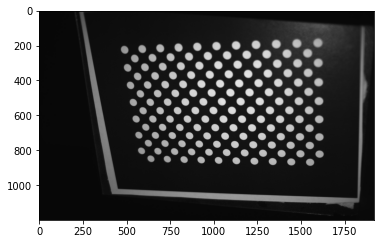

pose_01.png


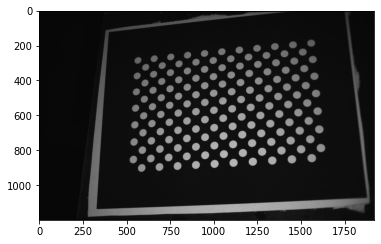

pose_02.png


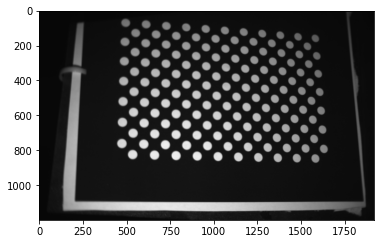

pose_03.png


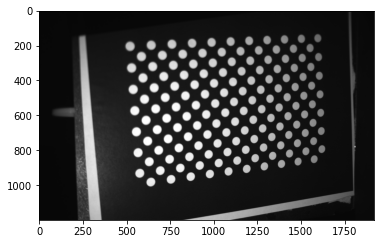

pose_04.png


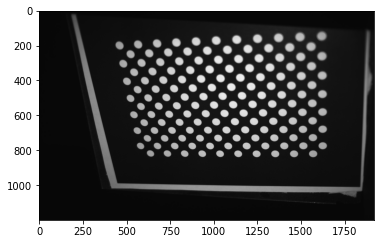

pose_05.png


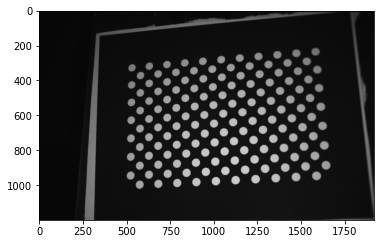

pose_06.png


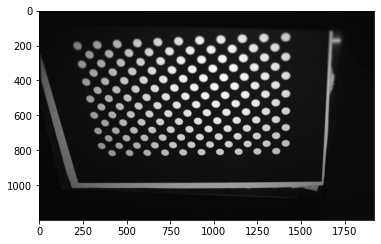

pose_07.png


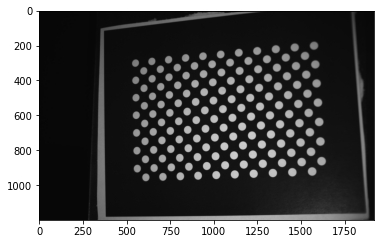

In [76]:
# Let's display the images
for i in range(0, NumImages):  
  img = cv2.imread(ImgBaseName.format(i))
  print(ImgBaseName.format(i))
  plt.imshow(img)
  plt.show()

=== Camera Calibration ===
Finding pattern circle centers in input images ...
pose_00.png
Found


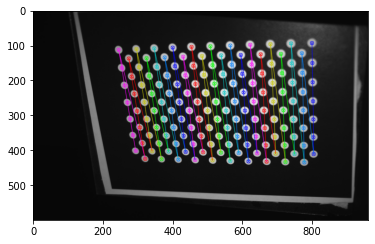

pose_01.png
Found


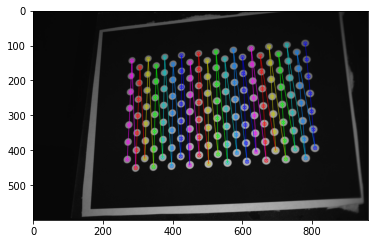

pose_02.png
Found


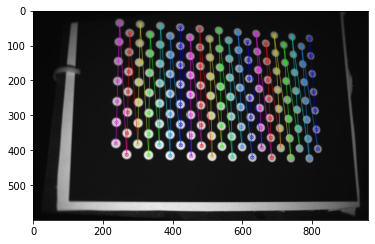

pose_03.png
Found


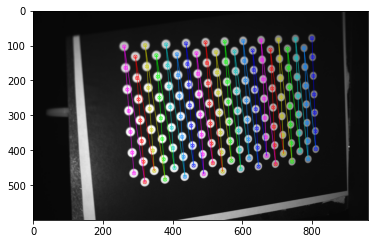

pose_04.png
Found


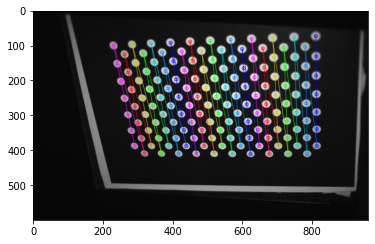

pose_05.png
Found


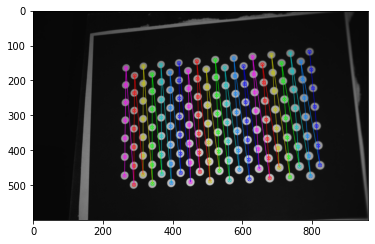

pose_06.png
Found


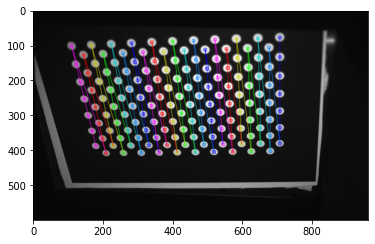

pose_07.png
Found


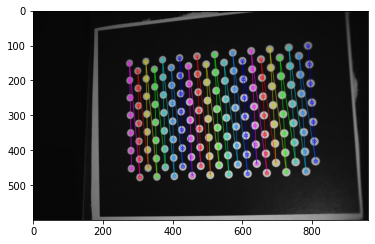

In [99]:
# This is the calibration code.
# It first loads the images, then it detects the grid pattern.

# Necessary input parameters
pattern_shape = (7, 21)
marker_size = 10

print('=== Camera Calibration ===')

DISPLAY_BLOBS = False

# Defining world object points
k = 0;
objp = np.zeros((pattern_shape[0]*pattern_shape[1], 3), np.float32)
for i in range(pattern_shape[1]):
    for j in range(pattern_shape[0]):
        objp[k] = np.array([(2.0*j+np.mod(i,2))*marker_size, i*marker_size, 0])
        k += 1

# blob detector 
params = cv2.SimpleBlobDetector_Params()
# params.minArea = 10
# params.minDistBetweenBlobs = 5
params.filterByColor = True
params.blobColor = 255 # white circles
detector = cv2.SimpleBlobDetector_create(params)

print('Finding pattern circle centers in input images ...')
objp_list = []
imgp_list = []
img_shape = None

# for f in filenames:
for k in range(0, NumImages):
    # print('  ' + ImgBaseName.format(i) + ' : ', end='')
    print(ImgBaseName.format(k))
    # img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(ImgBaseName.format(k))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if img_shape is None:
        img_shape = gray.shape
    elif img_shape != gray.shape:
        print('Mismatch size')
        continue

    # Display detected blobs
    if DISPLAY_BLOBS:
      keyPoints = detector.detect(gray)
      
      for i in range(len(keyPoints)):
          keypoint = keyPoints[i]
      
          x = int(keypoint.pt[0])
          y = int(keypoint.pt[1])
          s = keypoint.size
          r = int(np.floor(s / 2))
          cv2.circle(img, (x, y), r, (255, 0, 0), 3)
      # cv2_imshow(img)
      plt.imshow(img)
      plt.show()

    ret, centers = cv2.findCirclesGrid(gray, pattern_shape, 
                                       flags=(cv2.CALIB_CB_ASYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING), 
                                       blobDetector=detector)
    # If the circles grid is found
    if ret:
        print('Found')
        objp_list.append(objp)
        imgp_list.append(centers)
        # Draw and display the centers
        img_half = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
        img_half = cv2.drawChessboardCorners(img_half, pattern_shape, centers/2, ret)
        plt.imshow(img_half)
        plt.show()
    else:
        print('Not found')


In [79]:
# Let's calibrate the camera

CALIBFLAG = 0  # cv2.CALIB_FIX_K3

print(' ', len(objp_list), 'images are used')
ret, cam_int, cam_dist, rvecs, tvecs = cv2.calibrateCamera(
    objp_list, imgp_list, img_shape, None, None, None, None, CALIBFLAG
)
np.set_printoptions(suppress=True)
print('Image size :', img_shape)
print('RMS :', ret)
print('Intrinsic parameters :')
print(cam_int)
print('Distortion parameters :')
print(cam_dist)
print()

rmtxs = list(map(lambda vec: cv2.Rodrigues(vec)[0], rvecs))

fs = cv2.FileStorage('calibration.xml', cv2.FILE_STORAGE_WRITE)
fs.write('img_shape', img_shape)
fs.write('rms', ret)
fs.write('intrinsic', cam_int)
fs.write('distortion', cam_dist)
fs.write('rotation_vectors', np.array(rvecs))
fs.write('rotation_matrixes', np.array(rmtxs))
fs.write('translation_vectors', np.array(tvecs))
fs.release()


  8 images are used
Image size : (1200, 1920)
RMS : 0.26246772141270186
Intrinsic parameters :
[[2764.52682324    0.          968.28518763]
 [   0.         2745.66941422  609.47576246]
 [   0.            0.            1.        ]]
Distortion parameters :
[[-0.09587583 -1.16435747  0.00078134 -0.00120236 10.56579674]]



## TODO

1. Change the number of images and check if the intrinsic parameters remain the same.
2. What happens to the RMS error when you only use few images? One image?